<div style="border: 2px solid red; padding: 10px; border-radius: 5px;">
<strong>Notebook description:</strong>
    
Plotting WT vs p.Tyr622* LCMS lipidomics results

<strong>Input Data:</strong>

`5041.SUB14737_LipidXData.csv` 


<strong>Figures:</strong>

`Fig3`
`ED11`

<strong>Last Run All:</strong>
June 18, 2025


In [1]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')

from ABCA7lof2.utils import apply_custom_plot_style
apply_custom_plot_style()

In [2]:
import sys
sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
# load libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from adjustText import adjust_text
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D
import os

import os
import urllib.request
import os
import urllib.request
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests
os.sys.path.append('/Users/djuna/Documents/ABCA7lof2/')
from ABCA7lof2.lcms_funcs import return_stats, plot_volcano, plot_pca, count_unsaturations, count_carbons, plot_lfcs, plot_carbon_distributions, plot_class_counts, plot_with_blank, classify_fatty_acid_length, classify_unsaturation

load the data

In [3]:
# load the data

output_dir = "../../../LCMS/"

# load data
data = pd.read_csv(output_dir + '2685.SUB15127_LipidXData.csv')
data.index = data['name']

# load lipid key
key = pd.read_csv(os.path.join(output_dir, 'LipidKey.csv'))
dictionary = dict(zip(key['Key'], key['Class']))

# sample key 
sample_dictionary = {'s1':'Y+H2O',
                     's2':'E3+H2O',
                     's3':'Y+C',
                     's4':'G2+H2O',
                     'c':'blank'}

lipid_palette = {
    'Sphingolipids':'#1DC9A4',
    'Neutral lipids':'#E3120B',
    'Phospholipids':'#475ED1',
    'Fatty acyl and other lipids':'#F97A1F', 
    'Neutral glycerolipid':'#E3120B',	
    'Steroid':'#F9C31F', 
    'Glycoglycerolipids':'darkblue'
}

pufa_palette = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1'
}

perform stats

In [4]:
# get areas
areas = data[[col for col in data.columns if col.startswith('area[')]]
names = np.array([x.split('[')[1].split('-')[0] for x in areas.columns])
areas_columns = np.array([sample_dictionary[x] for x in names])

# remove blanks
areas_no_blank = areas.iloc[:,(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O')]
names_no_blank = areas_columns[(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O')]

# get average extraction blank
ext_blank_h20 = areas.iloc[:, areas_columns == 'blank'].median(axis=1).squeeze() #.iloc[:,0:2]

# remove extraction blank
areas_no_blank_H20_blank_removed = areas_no_blank.subtract(3*ext_blank_h20, axis=0)

# set neg values to zero
areas_no_blank_H20_blank_removed_zeroed = areas_no_blank_H20_blank_removed.copy()
areas_no_blank_H20_blank_removed_zeroed[areas_no_blank_H20_blank_removed_zeroed < 0] = 0

# get significant compounds
stats = return_stats(areas_no_blank_H20_blank_removed_zeroed, names_no_blank, 'E3+H2O', 'Y+H2O')
stats['cat'] = 'other'
stats['name'] = stats.index
stats['grp'] = [dictionary[x.split('(')[0]] for x in stats.index]

# Drop rows where fold change is NaN
stats = stats.dropna(subset=['p_value'])

# correct pvalues
stats['fdr_corrected_p_value'] = multipletests(stats['p_value'], method='fdr_bh')[1]

# add class column
stats['class'] = [x.split('(')[0] for x in stats.index]

# add unsaturation and carbon length column 
stats['carbons'] = stats['name'].apply(count_carbons)
stats['unsaturations'] = stats['name'].apply(count_unsaturations)
stats['unsat_grp'] = [classify_unsaturation(count_unsaturations(x)) for x in stats.index]


# categorize species
stats['cat'] = 'other'
stats.loc[(stats['log2_fold_change']< -1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'down'
stats.loc[(stats['log2_fold_change']>1) & (stats['fdr_corrected_p_value']<0.05), 'cat'] = 'up'
stats['cat'] = stats['cat'].astype(str)

stats.head()


/Users/djuna/Documents/ABCA7lof2/ABCA7lof2/lcms_funcs.py:33: RuntimeWarning: divide by zero encountered in log2
  log2_fold_change = np.log2(mean_group2 / mean_group1) if mean_group1 != 0 else np.inf


,t_stat,p_value,log2_fold_change,fdr_corrected_p_value,cat,name,grp,class,carbons,unsaturations,unsat_grp
DG(18:0_16:0)+NH4_46.33,1.077612,0.307600,0.676965,0.403740,other,DG(18:0_16:0)+NH4_46.33,Neutral lipids,DG,34,0,SFA
DG(18:0e)+Na_34.38,-1.026205,0.331585,-inf,0.403740,other,DG(18:0e)+Na_34.38,Neutral lipids,DG,18,0,SFA
DG(23:5e)+H_37.99,1.000000,0.350617,inf,0.403740,other,DG(23:5e)+H_37.99,Neutral lipids,DG,23,5,PUFA
LPC(16:0)+H_29.72,2.849317,0.015551,1.281005,0.044501,up,LPC(16:0)+H_29.72,Phospholipids,LPC,16,0,SFA
LPC(16:2e)+H_28.54,1.321485,0.213571,0.700318,0.324628,other,LPC(16:2e)+H_28.54,Phospholipids,LPC,16,2,PUFA


Show replicates & save stats

In [5]:
np.unique(areas_columns, return_counts=True)

(array(['E3+H2O', 'G2+H2O', 'Y+C', 'Y+H2O', 'blank'], dtype='<U6'),
 array([10,  5,  8,  8,  4]))

In [6]:
stats.to_csv('../../../extended_tables/lcms_y622.csv')

In [7]:
np.unique(names_no_blank, return_counts=True)

(array(['E3+H2O', 'Y+H2O'], dtype='<U6'), array([10,  8]))

Look at Blanks

/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 10.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 50.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/djuna/Library/Python/3.9/lib/python/site-packages/seaborn/categorical.py:3399: UserWarning: 25.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/Users/djuna/Library/Python/3.9/lib/python/site-

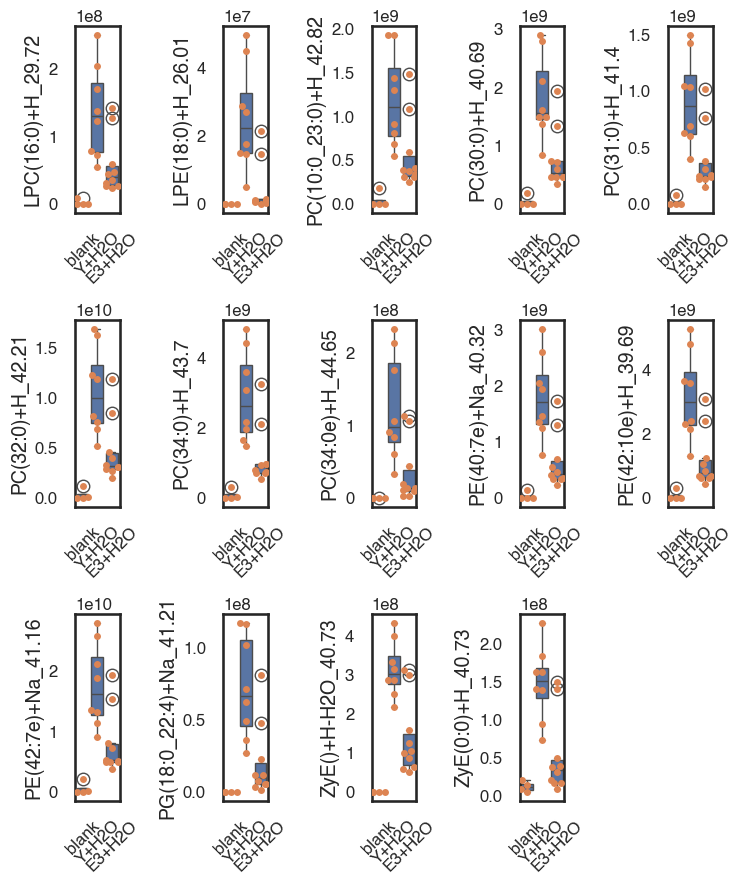

In [8]:
# show sig lipids with blanks
areas_sub = areas.loc[stats[(stats['fdr_corrected_p_value']<0.05) & (np.abs(stats['log2_fold_change'])>1)].index].iloc[:,(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O') | (areas_columns=='blank')]
areas_sub.columns = areas_columns[(areas_columns=='E3+H2O') | (areas_columns=='Y+H2O') | (areas_columns=='blank')]
areas_sub = areas_sub.T
areas_sub['grp'] = areas_sub.index
plot_with_blank(areas_sub)

Show perturbed lipids by cell type as table

In [9]:
# get # of perturbed lipids per subclass

subclass_dict = dict(zip(key['Key'], key['subclass']))
grouped = stats.groupby('class')['cat'].value_counts().unstack(fill_value=0)
grouped['down'] = 0
# Compute total species per class.
grouped['Total'] = grouped.sum(axis=1)

# Compute the total perturbed (up + down) and percentage.
grouped['Perturbed'] = grouped.get('up', 0) #+ grouped.get('down', 0)
grouped['% Perturbed'] = (grouped['Perturbed'] / grouped['Total'] * 100).round(1)
grouped['total'] = grouped['up'] + grouped['down']

# Create the summary table: absolute up, absolute down, and % perturbed.
table_df = grouped[['up', 'down', 'total', '% Perturbed']].rename(
    columns={'up': 'Up', 'down': 'Down', 'total': 'Total', 'empty': ''}
)

# subset table to only include classes with more than 0 total
table_df.sort_values(by='Total', ascending=False, inplace=True)
table_df = table_df.loc[table_df['Total']>0].copy()

# add subclass
table_df['Subclass'] = [subclass_dict[x] for x in table_df.index]

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


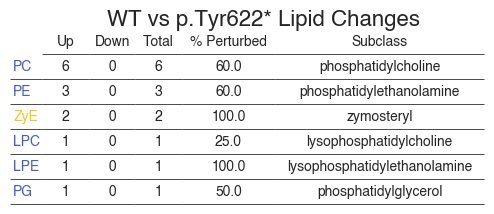

In [10]:
# plot the table 

table_palette = dict(zip(table_df.index, [lipid_palette[dictionary[x]] for x in table_df.index]))

fig, ax = plt.subplots(figsize=(3,2))
ax.axis('off')  # Hide the main axes

tbl = ax.table(cellText=table_df.values,
               rowLabels=table_df.index,
               colLabels=table_df.columns,
               cellLoc='center',
               loc='center', colWidths=[0.2, 0.2, 0.2, 0.4, 0.9])

tbl.auto_set_font_size(False)
tbl.set_fontsize(10)
tbl.scale(1, 1.5)

# Color the row labels according to the palette.
# Matplotlib stores row labels in cells with (row, col) where col == -1.
for (row, col), cell in tbl.get_celld().items():
    if col == 0 and row > 0:  # row>0: skip header row label cell
        lipid_class = table_df.index[row-1]  # row labels start at row 1 in the table cells
        cell.set_facecolor(table_palette.get(lipid_class, 'blue'))

for key, cell in tbl.get_celld().items():
    
        cell.set_edgecolor('white')

for (row, col), cell in tbl.get_celld().items():
    if row > 0:  # for all cells in data rows
        # Show only the bottom edge:
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)
    else:
        # For header row, you can keep the default (or set a full box if desired)
        cell.visible_edges = 'B'
        cell.set_edgecolor('black')
        cell.set_linewidth(0.5)

    if col == -1 and row > 0:  # skip header label cell if present
        lipid_class = table_df.index[row-1]  # adjust index for header offset
        cell.get_text().set_color(table_palette.get(lipid_class, 'black'))
plt.title('WT vs p.Tyr622* Lipid Changes', fontweight="bold", pad=10)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/lipids_table_y622.pdf', dpi=300, bbox_inches='tight')


Show TG chain length distribution

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


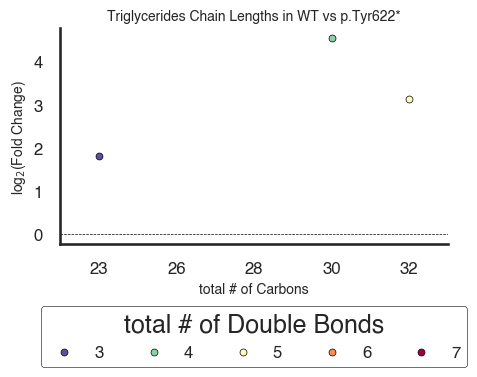

In [11]:
temp = stats[stats['class']=='TG'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='carbons', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'unsaturations', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Double Bonds')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Carbons', fontsize=10)
plt.title('Triglycerides Chain Lengths in WT vs p.Tyr622*', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/tg_carbons_y622.pdf', dpi=300, bbox_inches='tight')


show PC distribution 

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


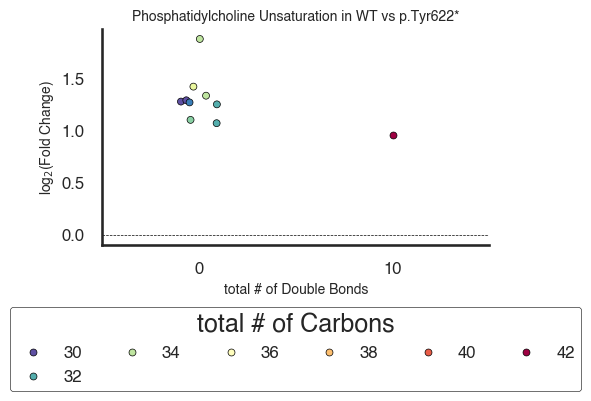

In [12]:
temp = stats[stats['class']=='PC'].copy()
plt.figure(figsize=(5, 2.8))
#
sp = sns.stripplot(data=temp, x='unsaturations', y='log2_fold_change', jitter=0.1, alpha = 1, hue = 'carbons', color = 'black', palette = 'Spectral_r', edgecolor='black', linewidth=0.5)

sp.spines['top'].set_visible(False)
sp.spines['right'].set_visible(False)

legend = plt.legend(bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=6, frameon=True, title='total # of Carbons')
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(0.5)
plt.ylabel('log$_{2}$(Fold Change)', fontsize=10)
plt.xlabel('total # of Double Bonds', fontsize=10)
plt.title('Phosphatidylcholine Unsaturation in WT vs p.Tyr622*', fontsize=10)
plt.axhline(0, color='black', linewidth=0.5, linestyle='--')

#plt.xlim(-1,9)
plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/pc_unsat_y622.pdf', dpi=300, bbox_inches='tight')


For some PC species, we don't have the resolution to determine whether they are MUFA or PUFA

Remove ambiguous PCs:

In [13]:
import re

def is_x1_y1_format(lipid_annotation):
    # Extract the part inside the parentheses.
    match = re.search(r'\(([^)]*)\)', lipid_annotation)
    if not match:
        return False
    chains_str = match.group(1)
    
    # Split the string into two fatty acid chains
    parts = chains_str.split('_')
    if len(parts) != 2:
        return False
    
    # Define regex for a fatty acid in the format: optional letters, digits, colon, and exactly '1'
    pattern = re.compile(r'^[a-zA-Z]*\d+:1$')
    
    # Check if both parts match the expected x:1 format.
    return all(pattern.match(part) for part in parts)

def count_unsaturations(lipid_name):
    """
    Count the total number of unsaturated bonds in a lipid species name.
    The function extracts the substring within parentheses and finds all occurrences
    of a pattern where a colon is followed by a number (e.g., '10:1').
    It returns the sum of these numbers.
    """
    # Extract the content inside parentheses
    m = re.search(r'\((.*?)\)', lipid_name)
    if m:
        inside = m.group(1)
        # Find all numbers that follow a colon (e.g., in "10:1", captures "1")
        unsat_numbers = re.findall(r':(\d+)', inside)
        if unsat_numbers:
            return sum(int(num) for num in unsat_numbers)
    # Return 0 if no unsaturation information is found
    return 0

def is_ambiguous_lipid(lipid_annotation):
    """
    Returns True if the lipid annotation is ambiguous.
    A lipid is considered ambiguous if:
      - Its fatty acyl chains are provided as a sum composition (i.e. no underscore in the parentheses), AND
      - The double bond count in that sum composition is exactly 2 (e.g., "20:2").
    
    Examples:
      - "ZyE(20:2)+H_52.77" returns True.
      - "ZyE(20:3)+H_52.77" returns False (because the double bond count is not 2).
      - "PC(19:1_18:1)+HCOO_45.79" returns False (because two chains are specified).
    """
    # Extract the substring inside the parentheses
    match = re.search(r'\(([^)]*)\)', lipid_annotation)
    if not match:
        return False
    acyl_str = match.group(1)
    
    # If an underscore is present, it means the fatty acids are given as separate chains (unambiguous)
    if '_' in acyl_str:
        return False

    # Check if the acyl chain follows the x:2 format (with optional letter prefixes)
    pattern = re.compile(r'^[a-zA-Z]*\d+:2$')
    return bool(pattern.match(acyl_str))

# Example usages:
print(is_ambiguous_lipid("ZyE(20:2)+H_52.77"))      # Expected output: True
print(is_ambiguous_lipid("ZyE(20:3)+H_52.77"))      # Expected output: False
print(is_ambiguous_lipid("PC(19:1_18:4)+HCOO_45.79")) # Expected output: False
print(is_ambiguous_lipid("Lipid(17:2)+H"))            # Expected output: True
print(is_ambiguous_lipid("Lipid(17:1)+H"))            # Expected output: False

True
False
False
True
False


In [14]:
# update unsaturation group for missed MUFA 
stats['is_missed_mufa'] = stats['name'].apply(is_x1_y1_format)
stats['is_ambiguous_lipid'] = stats['name'].apply(is_ambiguous_lipid)
stats.loc[stats['is_missed_mufa'],'unsat_grp'] = 'MUFA'
stats = stats[np.invert(stats['is_ambiguous_lipid'])]

Show saturated PCs

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


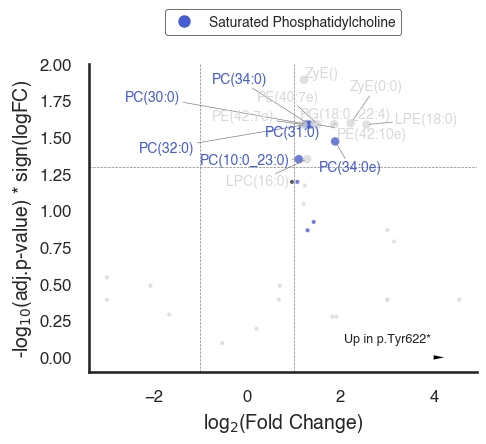

In [15]:
subset = stats.copy()
subset.loc[subset['class'] != 'PC', 'unsat_grp'] = 'other'
subset.loc[subset['log2_fold_change']==-np.inf, 'log2_fold_change'] = -3
subset.loc[subset['log2_fold_change']==np.inf, 'log2_fold_change'] = 3

palette_temp = {
    'PUFA':'#333333',
    'MUFA':'#1F2E7A',
    'SFA':'#475ED1',
    'other': '#D9D9D9'
}

plot_volcano('fdr_corrected_p_value', 'name', 'unsat_grp', 'log2_fold_change',subset, palette_temp, force_text=15, max_size=40, alpha=.8, subset_top_genes_by_lfc=True)

#plt.xlim(-2,3)
plt.ylim(-0.1,2)

plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(3, .1, 'Up in p.Tyr622*', ha='center', fontsize=9)

# plt.annotate('', xy=(-4.5,0), xytext=(-1, 0),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
# plt.text(-2.8, .1, 'Down in p.Glu50fs*3', ha='center', fontsize=10)

labels = [
    'SFA']

handles = [
    Line2D([0], [0], marker='o', color='w', label='Saturated Phosphatidylcholine',
           markerfacecolor=palette_temp[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='upper center', bbox_to_anchor=(.5, 1.2), ncol=3, frameon=True, fontsize=10)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)

plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/ed11/Y622_PC_volcano_sat.pdf', dpi=300, bbox_inches='tight')



Show all lipids

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp
Zapf NOT subset; don't know how to subset; dropped
feat NOT subset; don't know how to subset; dropped
meta NOT subset; don't know how to subset; dropped
morx NOT subset; don't know how to subset; dropped


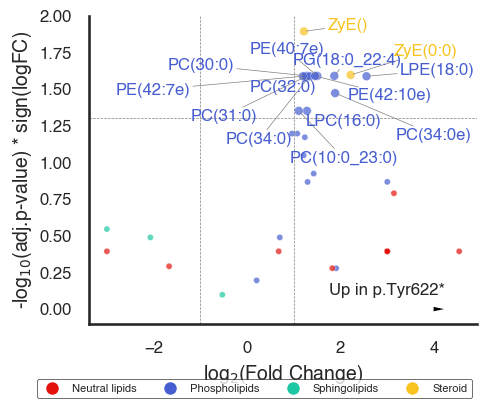

In [16]:
stats_for_volcano = stats.copy()
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==-np.inf, 'log2_fold_change'] = -3
stats_for_volcano.loc[stats_for_volcano['log2_fold_change']==np.inf, 'log2_fold_change'] = 3

plot_volcano('fdr_corrected_p_value', 'name', 'grp', 'log2_fold_change',stats_for_volcano, lipid_palette, label_size=12, force_text=10, min_size=20, max_size=40, alpha=0.7, subset_top_genes_by_lfc=True)

plt.ylim(-0.1,2)
#plt.xlim(-4,2.5)
plt.axvline(x=-1, color='grey', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='grey', linestyle='--', linewidth=0.5)
plt.axhline(y=1.3, color='grey', linestyle='--', linewidth=0.5)

plt.xlabel('log$_{2}$(Fold Change)')
plt.ylabel('-log$_{10}$(adj.p-value) * sign(logFC)')

plt.annotate('', xy=(4.5,0), xytext=(1, 0),
             arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
plt.text(3, .1, 'Up in p.Tyr622*', ha='center', fontsize=12)

# plt.annotate('', xy=(-2,0), xytext=(-1, 0),
#              arrowprops=dict(facecolor='black', shrink=0.05, width=.5, headwidth=5))
# plt.text(-2.3, .1, 'Down in p.Tyr622*\n+ CDP-choline', ha='center', fontsize=10)


labels = np.unique(stats_for_volcano['grp'])[[x!='Neutral glycerolipid' for x in np.unique(stats_for_volcano['grp'])]]
handles = [
    Line2D([0], [0], marker='o', color='w', label=label,
           markerfacecolor=lipid_palette[label], markersize=10)
    for label in labels
]

legend = plt.legend(handles=handles, loc='center left', bbox_to_anchor=(-0.15, -0.21), ncol=4, frameon=True, fontsize=8)
legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(.5)


plt.savefig('/Users/djuna/Documents/ABCA7lof2/editorial_paper/main_panels_svgs/fig3/all_lipids_y622.pdf', dpi=300, bbox_inches='tight')



Compute SFA / MUFA enrichment pvalue

In [17]:
import scipy.stats as STAT
#sf(k, M, n, N, loc=0)

def get_hypergeom_p_value(total_species, total_perturbed, total_subclass_size, subclass_perturbed):
    M = total_species              # Population size
    n = total_perturbed            # Total number of successes in the population
    N = total_subclass_size        # Number of draws
    x = subclass_perturbed         # Observed successes in the sample
    p_value = STAT.hypergeom.sf(x-1, M, n, N)
    return p_value

S = stats[stats['class']=='PC']
sfa_mufa_up_pval = get_hypergeom_p_value(stats.shape[0], stats['cat'].value_counts()['up'], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC')].shape[0], 
                      stats[(stats['unsat_grp']!='PUFA')&(stats['class']=='PC') & (stats['cat']=='up')].shape[0])

sfa_mufa_up_pval

0.043551356209900104